# Trailer: Bio-image Analysis with Python
In the following chapters we will dive into image analysis, machine learning and bio-statistics using Python. This first notebook serves as a trailer of what we will be doing.

Python notebooks typically start with the imports of Python libraries which the notebook will use. The reader can check first if all those libraries are installed before going through the whole notebook.

In [1]:
import numpy as np
from skimage.io import imread, imshow
import pyclesperanto_prototype as cle
from skimage import measure
import pandas as pd
import seaborn
import apoc
from stardist.models import StarDist2D 
from csbdeep.utils import normalize

## Working with image data
We start with loading the image data of interest. In this example we load an image showing a zebrafish eye, courtesy of Mauricio Rocha Martins, Norden lab, MPI CBG Dresden.

In [2]:
# open an image file
multichannel_image = imread("../../data/zfish_eye.tif")
print("Image size", multichannel_image.shape)

Image size (1024, 1024, 3)


From the three image channels, we extract one and visualize it.

_imshow.py (46): The imshow parameter color_map is deprecated. Use colormap instead.


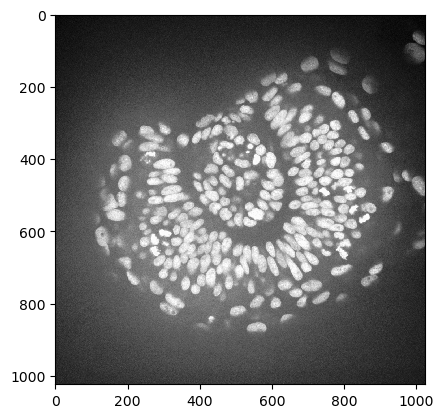

In [3]:
# extract a channel
single_channel_image = multichannel_image[:,:,0]

# visualizing an image
cle.imshow(single_channel_image, color_map='Greys_r')

We often don't work on the whole image to setup image analysis routines, we instead crop out interesting regions to concentrate on.

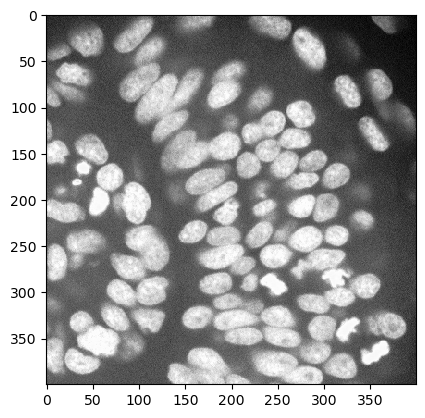

In [4]:
cropped_image = single_channel_image[200:600, 500:900]

cle.imshow(cropped_image, color_map='Greys_r')

## Image filtering

A common step when working with fluorescence microscopy images is subtracting background intensity, e.g. resulting from out-of-focus light. This can improve image segmentation results further down in the workflow.

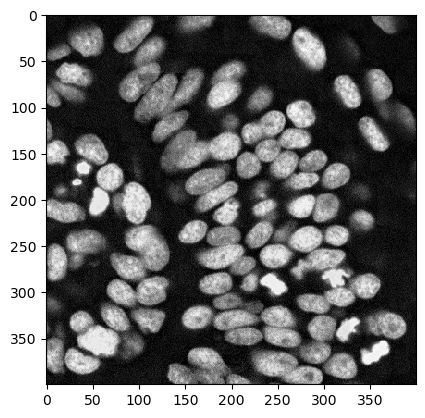

In [5]:
# subtract background using a top-hat filter
background_subtracted_image = cle.top_hat_box(cropped_image, radius_x=20, radius_y=20)

cle.imshow(background_subtracted_image, color_map='Greys_r')

## Image segmentation
For segmenting the nuclei in the given image, a huge number of algorithms exist. Modern approaches of deep-learning are gaining more and more attention because once trained, deep-learning based models are very easy to use. For example, there are models for segmenting nuclei using the [CellPose](https://cellpose.readthedocs.io/) algorithm. It will result in a label image visualizing all nuclei in different colors.

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
1/1 [==============================] - 0s 227ms/step


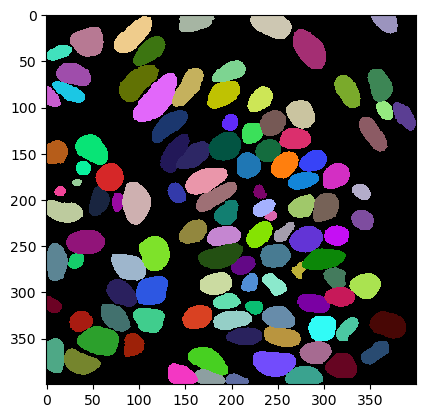

In [6]:
# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

axis_norm = (0,1)
normalized_image = normalize(background_subtracted_image, 1,99.8, axis=axis_norm)

label_image, details = model.predict_instances(normalized_image)

# show result
cle.imshow(label_image, labels=True)

## Measurements and feature extraction
After the image is segmented, we can measure properties of the individual objects. Those properties are typically descriptive statistical parameters, called features. When we derive measurements such as the area or the mean intensity, we extract those two features.

In [7]:
statistics = measure.regionprops_table(label_image, 
                                       intensity_image=cropped_image,
                                       properties=('area', 'mean_intensity', 'major_axis_length', 'minor_axis_length'))

## Working with tables
The `statistics` object created above contains a Python data structure, a dictionary of measurement vectors, which is not most intuitive to look at. Hence, we convert it into a table. Data scientists often call these tables DataFrames, which are available in the [pandas](https://pandas.pydata.org/) library.

In [8]:
# show table
dataframe = pd.DataFrame(statistics)
dataframe

,area,mean_intensity,major_axis_length,minor_axis_length
0,594.0,40572.809764,28.611591,26.537947
1,645.0,43764.872868,33.511511,24.566916
2,1105.0,51970.561991,45.232031,31.456308
3,718.0,47015.487465,31.023274,29.520883
4,791.0,49132.515803,36.382253,27.718301
...,...,...,...,...
105,238.0,30477.126050,20.252197,15.276536
106,615.0,32886.154472,41.030760,19.874280
107,110.0,33042.445455,14.366347,9.945911
108,222.0,43304.180180,25.370549,11.637599


We can use existing table columns to compute other measurements, such as the `aspect_ratio`.

In [9]:
dataframe['aspect_ratio'] = dataframe['major_axis_length'] / dataframe['minor_axis_length']
dataframe

,area,mean_intensity,major_axis_length,minor_axis_length,aspect_ratio
0,594.0,40572.809764,28.611591,26.537947,1.078139
1,645.0,43764.872868,33.511511,24.566916,1.364091
2,1105.0,51970.561991,45.232031,31.456308,1.437932
3,718.0,47015.487465,31.023274,29.520883,1.050892
4,791.0,49132.515803,36.382253,27.718301,1.312572
...,...,...,...,...,...
105,238.0,30477.126050,20.252197,15.276536,1.325706
106,615.0,32886.154472,41.030760,19.874280,2.064516
107,110.0,33042.445455,14.366347,9.945911,1.444448
108,222.0,43304.180180,25.370549,11.637599,2.180050


## Plotting
Measurements can be visualized using plots.

<AxesSubplot: xlabel='area', ylabel='aspect_ratio'>

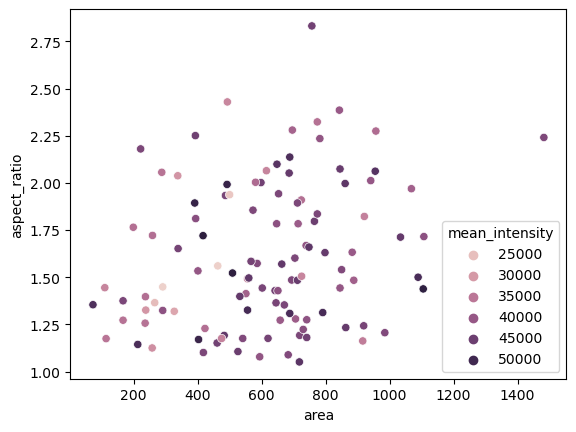

In [10]:
seaborn.scatterplot(dataframe, x='area', y='aspect_ratio', hue='mean_intensity')

## Descriptive statistics
Taking this table as a starting point, we can use statistics to get an overview about the measured data.

In [11]:
mean_area = np.mean(dataframe['area'])
stddev_area = np.std(dataframe['area'])

print("Mean nucleus area is", mean_area, "+-", stddev_area, "pixels")

Mean nucleus area is 612.1636363636363 +- 253.5312255207425 pixels


## Spatial statistics
When studying how cells are forming tissues, relationships of the cells to the local environment, their neighboring cells, are highly relevant. We can visualize those relationships for example in a distance mesh, where distances between centroids of nuclei are color-coded.

_imshow.py (46): The imshow parameter color_map is deprecated. Use colormap instead.


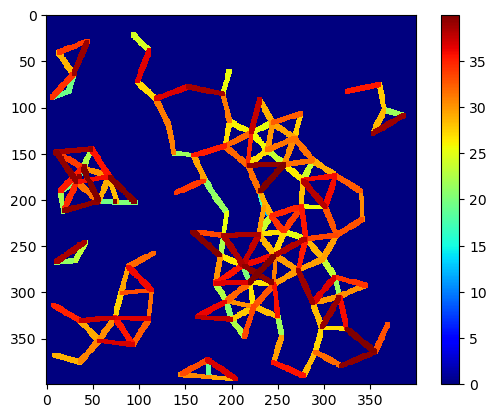

In [12]:
distance_mesh = cle.draw_distance_mesh_between_proximal_labels(
                    label_image, 
                    maximum_distance=40)

# for visualization purposes we make the lines a bit thicker
distance_mesh = cle.maximum_box(distance_mesh, radius_x=2, radius_y=2)

cle.imshow(distance_mesh, 
           colorbar=True, 
           color_map='jet')

## Visualization
Measurements such as distances between neighbors can also be summarized for each individual cell. We can for example color-code the average distance of each cell to its _n_ nearest neighbors and with that, highlight dense areas. Such a visualization is referred to as parametric map image.

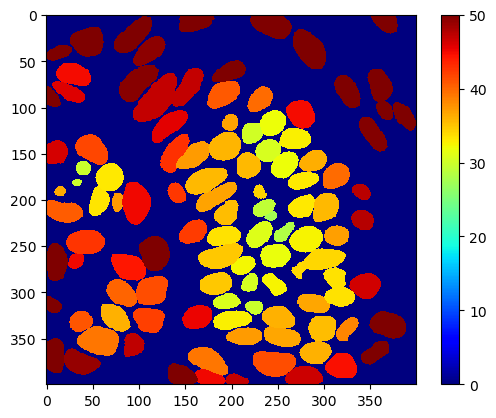

In [13]:
average_distance_map = cle.average_distance_of_n_nearest_neighbors_map(
                            label_image,
                            n=6)

cle.imshow(average_distance_map, 
           colorbar=True, 
           color_map='jet', 
           max_display_intensity=50)

We can also take measurements from the table above and create a visualization where we see those values color-coded.

In [14]:
# We add 0 to the list at the beginning. 
# It represents the measurements of the background
area = [0] + dataframe['area'].tolist()

print(area)

[0, 594.0, 645.0, 1105.0, 718.0, 791.0, 598.0, 719.0, 620.0, 706.0, 863.0, 541.0, 586.0, 919.0, 688.0, 551.0, 602.0, 730.0, 798.0, 739.0, 694.0, 941.0, 483.0, 658.0, 916.0, 741.0, 418.0, 663.0, 741.0, 845.0, 532.0, 712.0, 883.0, 642.0, 1089.0, 647.0, 683.0, 556.0, 560.0, 509.0, 461.0, 671.0, 1068.0, 704.0, 714.0, 213.0, 955.0, 526.0, 725.0, 765.0, 850.0, 696.0, 1034.0, 556.0, 394.0, 423.0, 573.0, 688.0, 748.0, 291.0, 888.0, 651.0, 487.0, 1107.0, 493.0, 985.0, 724.0, 861.0, 845.0, 258.0, 391.0, 339.0, 957.0, 403.0, 782.0, 236.0, 774.0, 686.0, 843.0, 712.0, 492.0, 199.0, 327.0, 567.0, 1482.0, 757.0, 417.0, 921.0, 73.0, 401.0, 237.0, 114.0, 774.0, 259.0, 581.0, 463.0, 338.0, 288.0, 266.0, 291.0, 653.0, 648.0, 167.0, 500.0, 393.0, 475.0, 238.0, 615.0, 110.0, 222.0, 167.0]


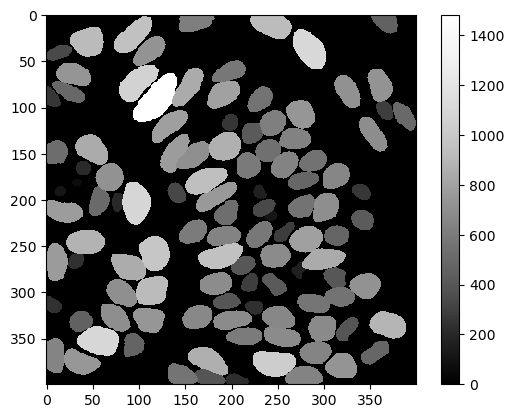

In [15]:
parametric_image = cle.replace_intensities(label_image, area)

cle.imshow(parametric_image, colorbar=True)

## Classification
For better understanding the internal structure of tissues, but also to correct for artifacts in image processing workflows, we can classify cells, for example according to their size and shape.

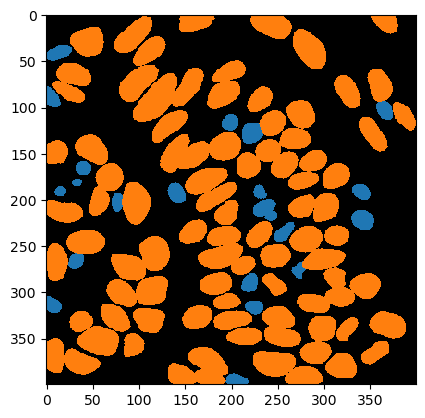

In [16]:
object_classifier = apoc.ObjectClassifier('../../data/blobs_classifier.cl')
classification_image = object_classifier.predict(label_image, cropped_image)

cle.imshow(classification_image, labels=True)